# MNIST Classification with MLP -- High Level API (tf.keras) --
In this notebook, I describe how to implement MLP using tf.keras API.

In [1]:
import tensorflow as tf
import time
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import os
%matplotlib inline

print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("scikit learn version: ", sklearn.__version__)
print("matplotlib version: ", matplotlib.__version__)

tf.enable_eager_execution()

tensorflow version:  1.15.2
numpy version:  1.18.2
scikit learn version:  0.22.2.post1
matplotlib version:  3.2.0


## 1. Load data & preprocessing
In this notebook, I use pre-defined mnist dataset.

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
# Convert images into flattern array
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [4]:
# Normalize
X_train = X_train / 255.0
X_test = X_test / 255.0

In [5]:
# Convert into float32
X_train = np.float32(X_train)
X_test = np.float32(X_test)

In [6]:
# Split original training dataset into train/validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True)

## 2. Create tf.data.Dataset

In [7]:
train_batch_size = 64
test_batch_size = 1
n_classes = 10

# Build source dataset for training
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset)).batch(train_batch_size).repeat()

# Build source dataset for validation
X_valid_dataset = tf.data.Dataset.from_tensor_slices(X_val)
y_valid_dataset = tf.data.Dataset.from_tensor_slices(y_val).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
validation_dataset = tf.data.Dataset.zip((X_valid_dataset, y_valid_dataset)).batch(train_batch_size).repeat()

# Build source dataset for test
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test).map(lambda x : tf.cast(tf.one_hot(x, n_classes), tf.float32))
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset)).batch(test_batch_size).repeat()

### Debug dataset

In [8]:
def visualize_batch(X_batch, y_batch, y_pred=None):
    """visualize 1D ndarray"""
    assert len(X_batch) == len(y_batch)
    
    n_col = 10
    if len(X_batch) % n_col ==0:
        n_row=len(X_batch)//n_col
    else:
        n_row=len(X_batch)//n_col + 1
    
    fig = plt.figure(figsize=(20,15))
    
    for idx in range(len(y_batch)):
        if y_pred is not None:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}, pred={}".format(np.argmax(y_batch[idx]), y_pred[idx]))
        else:
            ax = fig.add_subplot(n_row, n_col, idx+1, title="gt={}".format(np.argmax(y_batch[idx])))
        ax.imshow(X_batch[idx].reshape(28,28), cmap='gray')
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
    plt.show()

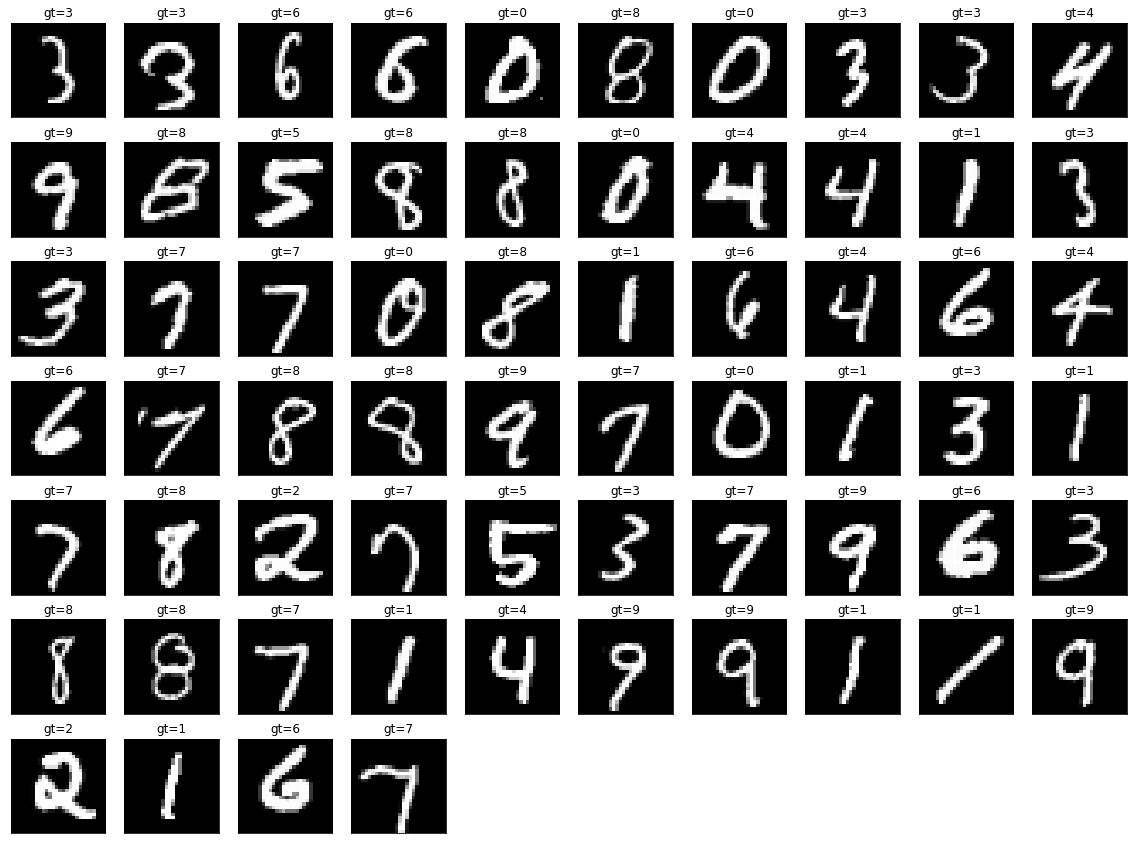

In [9]:
for X_batch, y_batch in train_dataset:
    visualize_batch(X_batch.numpy(), y_batch.numpy())
    break

## 3. Create MLP model

Network structure (2 hidden layers):  
FC(256) - FC(512) - FC(10) - SOFTMAX

In [10]:
n_input = 784
n_dense1 = 256
n_dense2 = 512
n_dense3 = n_classes

### Define network
By creating model as an inherited class of tf.keras.Model, we can easily train model by fit() method. 

In [11]:
class MLP(tf.keras.Model):
    def __init__(self, units1, units2, units3):
        super(MLP, self).__init__(name="MLP")
        self.dense1 = tf.keras.layers.Dense(units1, activation=None, kernel_initializer=tf.initializers.truncated_normal(stddev=0.1))
        self.dense2 = tf.keras.layers.Dense(units2, activation=None, kernel_initializer=tf.initializers.truncated_normal(stddev=0.1))
        self.dense3 = tf.keras.layers.Dense(units3, activation=None, kernel_initializer=tf.initializers.truncated_normal(stddev=0.1))
    
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

## 4. Training

In [12]:
lr = 0.0001
iter_per_epoch = X_train.shape[0] // train_batch_size
epochs = 15
checkpoint_path = './checkpoints_3/model_{epoch:04d}.ckpt'

model = MLP(n_dense1, n_dense2, n_dense3)
model.compile(optimizer=tf.train.AdamOptimizer(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_freq='epoch'),
]

model.fit(train_dataset, epochs=15, steps_per_epoch=int(len(X_train)/train_batch_size),
          validation_data=validation_dataset, validation_steps=int(len(X_val)/train_batch_size), callbacks=callbacks)

Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
750/750 [==============================] - 3s 5ms/step - loss: 0.1267 - acc: 0.9264 - val_loss: 0.0866 - val_acc: 0.9717
Epoch 2/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0803 - acc: 0.9726 - val_loss: 0.0786 - val_acc: 0.9749
Epoch 3/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0740 - acc: 0.9752 - val_loss: 0.0748 - val_acc: 0.9761
Epoch 4/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0705 - acc: 0.9764 - val_loss: 0.0725 - val_acc: 0.9767
Epoch 5/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0682 - acc: 0.9772 - val_loss: 0.0712 - val_acc: 0.9769
Epoch 6/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0667 - acc: 0.9775 - val_loss: 0.0703 - val_acc: 0.9771
Epoch 7/15
750/750 [==============================] - 3s 4ms/step - loss: 0.0656 - acc: 0.9779 - val_loss: 0.0698 

## 5. Test

In [13]:
model.evaluate(test_dataset, steps=len(y_test))

10000/10000 [==============================] - 9s 869us/step - loss: 0.0660 - acc: 0.9792


[0.06604287268799583, 0.9792155]

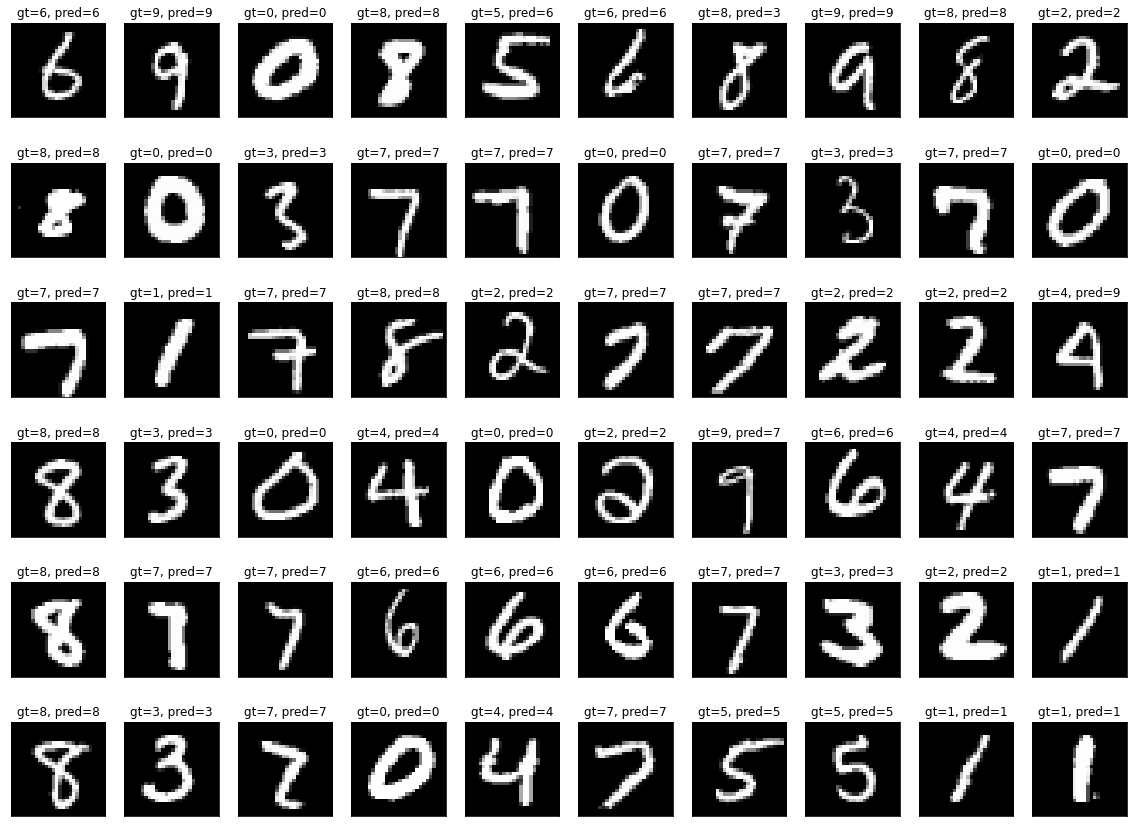

In [14]:
index = np.random.choice(np.arange(0, len(y_test)), size=60)
test_input = X_test[index]
y_true = tf.keras.utils.to_categorical(y_test[index], num_classes=n_classes)

predicted = model.predict(test_input)
predicted_label = np.argmax(predicted, axis=1)

visualize_batch(test_input, y_true, predicted_label)